In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import os

from multiprocessing import Pool, Manager, Value
import multiprocessing as mp

## 棋譜ファイルの前処理

In [2]:
with open("../data/kif/AbemaTV_Tournament_Takami_vs_Kubo_analized.kif", "r") as k:
    kif = k.readlines()

In [3]:
apery_eval = [k.split(" ")[1] for k in kif[11::2]]

## 動画ファイルから目的変数の作成

In [4]:
cap = cv2.VideoCapture("/media/nvidia/ST_USB32G/AbemaTV_tournament_takami_vs_kubo_movie.mp4")

In [5]:
n_frame = 6

frame_all = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_idx = [_ for _ in range(frame_all) if _%n_frame == 0]

In [6]:
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx[0])
_, frame = cap.read()

img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

先手番と後手番を見極めるため指し手を示す赤色の矩形を元に決める

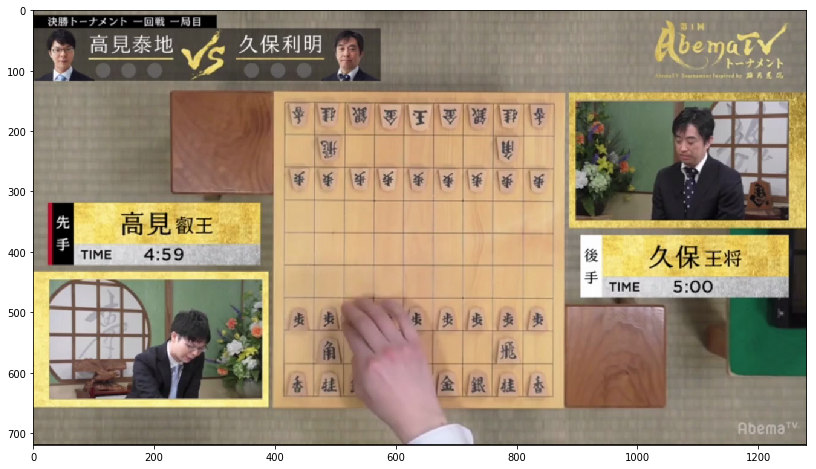

In [7]:
plt.figure(figsize=(18,8))
plt.imshow(img)

In [8]:
img[350][20:30]

array([[148, 140, 124],
       [148, 140, 124],
       [171, 129, 124],
       [157, 115, 110],
       [173,  56,  76],
       [152,  35,  55],
       [181,  13,  40],
       [182,  15,  41],
       [190,  11,  42],
       [190,  11,  42]], dtype=uint8)

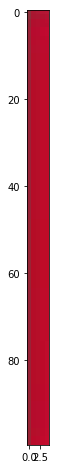

In [9]:
plt.figure(figsize=(18,8))
plt.imshow(img[320:420, 25:30])

In [10]:
move_df = pd.DataFrame(img[320:420, 25:30].reshape(500, 3), columns=["R", "G", "B"])

In [11]:
move_df.to_csv("../data/move_color.csv", index=False)

## 色情報を読み込み抽出したRGBの差を求める

In [12]:
move_df = pd.read_csv("../data/move_color.csv")
wait_df = pd.read_csv("../data/wait_color.csv")

In [13]:
# 平均値を取得
move_mean = move_df.mean()
wait_mean = wait_df.mean()

In [14]:
move_mean

R    178.756
G     17.266
B     44.596
dtype: float64

In [15]:
wait_mean

R    140.832
G    134.014
B    118.680
dtype: float64

In [16]:
sum(abs(move_mean - [140, 10, 40]))

50.617999999999995

In [17]:
sum(abs(wait_mean - [140, 10, 40]))

203.526

フレームをサンプリングするたびに上記の範囲の色素情報の平均を取り差の少ない方をパターンマッチングさせる

## OpenPoseで抽出した特徴量に目的変数を加える

In [18]:
p1_df = pd.read_csv("/media/nvidia/ST_SD16G/Research/data/player1_features_frame6_v2.csv", index_col=0)
p2_df = pd.read_csv("/media/nvidia/ST_SD16G/Research/data/player2_features_frame6_v2.csv", index_col=0)

In [19]:
p1_df.shape

(12446, 24)

cv2.cvtColorが並列実行のエラー

In [20]:
# is_player_dict = Manager().dict()
# apery_eval_dict = Manager().dict()
# flag_prev = Value("i", True)
# counter = Value("i", 0)

is_player_list, apery_eval_list = [], []
flag_prev, counter = True, 0

for idx in tqdm(frame_idx):
    cap = cv2.VideoCapture("/media/nvidia/ST_USB32G/AbemaTV_tournament_takami_vs_kubo_movie.mp4")
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    _, frame = cap.read()

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    check_playing_df = pd.DataFrame(img[320:420, 25:30].reshape(500, 3), columns=["R", "G", "B"])
    check = check_playing_df.mean()
    
    flag = sum(abs(move_mean - check)) < sum(abs(wait_mean - check))
    
    if flag:
        is_player_list.append(1)
    else:
        is_player_list.append(0)
        
    if flag_prev != flag:
        counter += 1
    apery_eval_list.append(apery_eval[counter])
    
    flag_prev = flag

# cv2.setNumThreads(0)
# with Pool(mp.cpu_count()) as p:
#     p.map(make_response_var, frame_idx, 1)

In [21]:
len(is_player_list)

12446

In [22]:
len(apery_eval_list)

12446

In [23]:
p1_df["is_player"] = is_player_list
p2_df["is_player"] = [0  if _ == 1 else 1 for _ in is_player_list] # 反転

In [24]:
p1_df["apery_eval"] = apery_eval_list
p2_df["apery_eval"] = apery_eval_list

In [25]:
output_path = "/media/nvidia/ST_SD16G/Research/output/"

In [26]:
p1_df.to_csv(os.path.join(output_path, "player1_features_frame6_v3.csv"))
p2_df.to_csv(os.path.join(output_path, "player2_features_frame6_v3.csv"))

In [49]:
p1_df.iloc[::300, 16:][2:]

,LElbow_y,LElbow_z,REye_x,REye_y,REye_z,LEye_x,LEye_y,LEye_z,is_player,apery_eval
600,370.75443,0.482209,1074.19890,239.50030,0.920893,0.00000,0.00000,0.000000,0,0
900,384.43997,0.459859,1087.83510,233.67563,0.939466,0.00000,0.00000,0.000000,1,31
1200,384.43948,0.461900,1068.19560,241.46240,0.932639,0.00000,0.00000,0.000000,0,70
1500,382.57450,0.486293,1072.12510,241.38637,0.978850,0.00000,0.00000,0.000000,0,202
1800,384.44840,0.530033,1074.18210,251.25417,0.883529,0.00000,0.00000,0.000000,1,57
2100,372.74347,0.541797,1062.34000,239.51825,0.888456,0.00000,0.00000,0.000000,1,143
2400,368.81775,0.558869,1070.12820,239.50444,0.897954,0.00000,0.00000,0.000000,1,-16
2700,372.73676,0.536494,1066.28520,241.44081,0.890715,0.00000,0.00000,0.000000,0,-76
3000,376.63727,0.559508,1066.28360,241.42992,0.884038,0.00000,0.00000,0.000000,1,17
3300,370.75430,0.567421,1072.13720,241.40344,0.960047,0.00000,0.00000,0.000000,1,-78


## データの読み込み

In [28]:
p1_df = pd.read_csv(os.path.join(output_path, "player1_features_frame6_v3.csv"), index_col=0)
p2_df = pd.read_csv(os.path.join(output_path, "player2_features_frame6_v3.csv"), index_col=0)

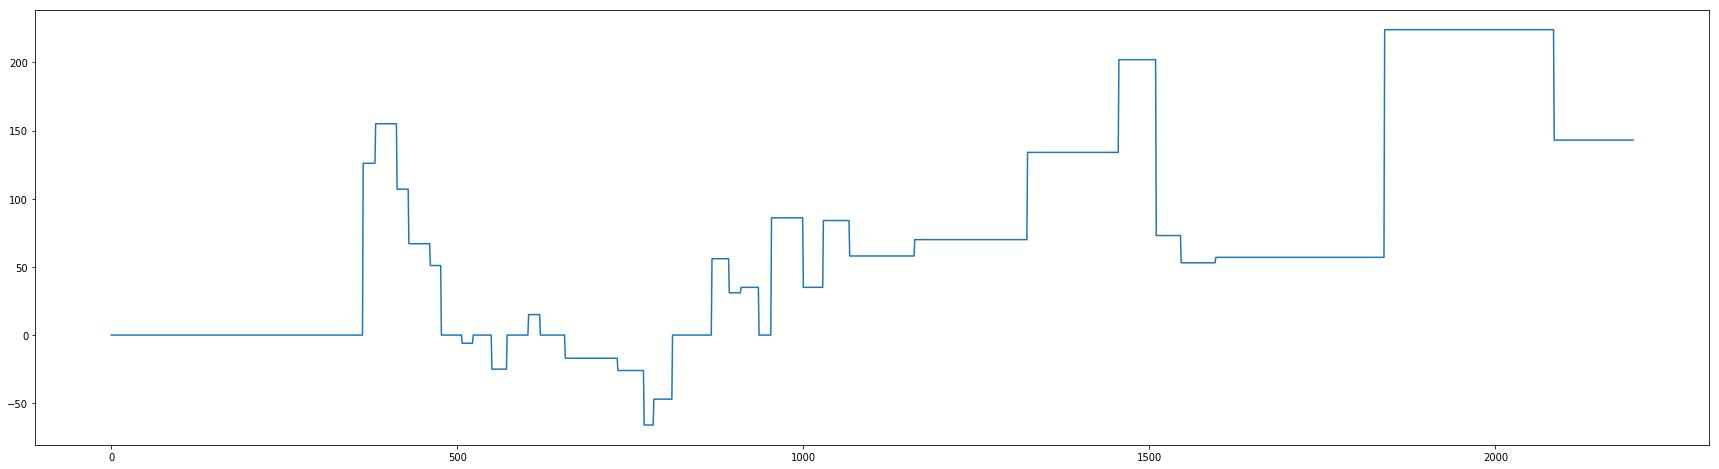

In [29]:
plt.figure(figsize=(30,8))
p1_df.apery_eval[:2200].astype("float32").plot()